# installations

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms


In [2]:
import numpy as np
import numpy.random as random
import matplotlib.pyplot as plt



In [3]:
import torch.nn as nn
import torch.nn.functional as F

In [4]:
!pip install torcheval

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.2/179.2 kB 1.7 MB/s eta 0:00:00


In [5]:
from torcheval.metrics.functional import multiclass_f1_score
from torcheval.metrics import MulticlassRecall , MulticlassPrecision


In [6]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [7]:
batch_size = 16
EPOCHS = 70

# Read Data

In [8]:

train_transform = transforms.Compose([
     transforms.RandomChoice([
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation((10,10)),
     transforms.ColorJitter(brightness = (0.7,1.2)),
    ]),
     transforms.Compose([
      transforms.Resize(size=64),
       transforms.ToTensor(),
       transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))])

])

transform = transforms.Compose(
    [transforms.Resize(size=64),
     transforms.ToTensor(),
     transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616)),
     ])


In [9]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=train_transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

100%|██████████| 170498071/170498071 [00:13<00:00, 12983194.51it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


## Random visualization

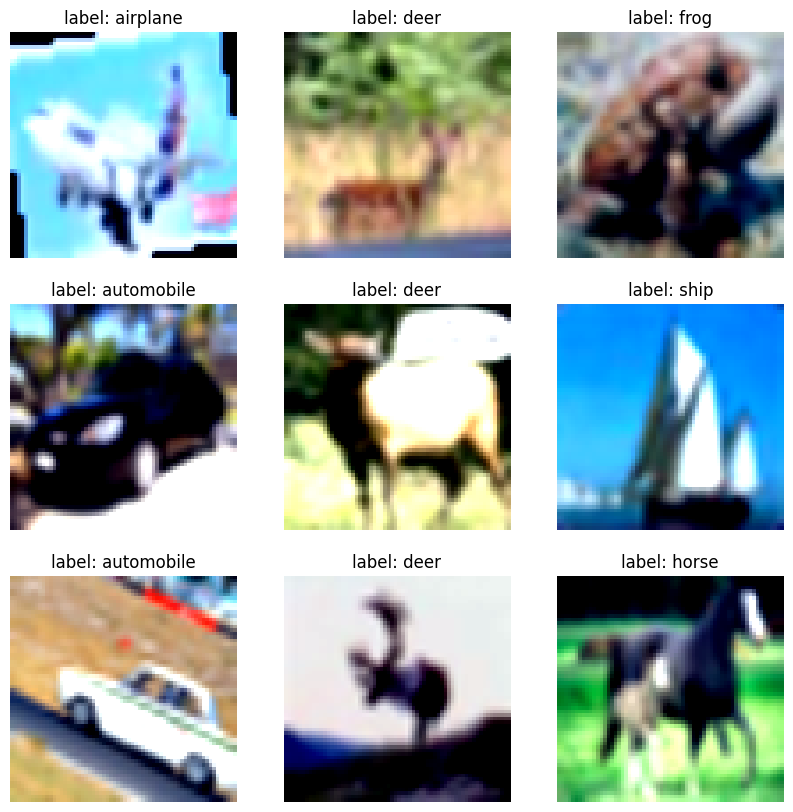

In [10]:
#random visualization
random_index = random.randint(400, size=9)
images = [trainset[i][0] for i in random_index]
labels = [trainset.classes[trainset[i][1]] for i in random_index]

plt.figure(figsize=(10,10))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow((images[i] / 2 + 0.5).permute(1, 2, 0) ) #chnage the indexes 32×32×3
    plt.title('label: {}'.format(labels[i]))
    plt.axis('off')

Text(0.5, 1.0, 'Class distribution in training set')

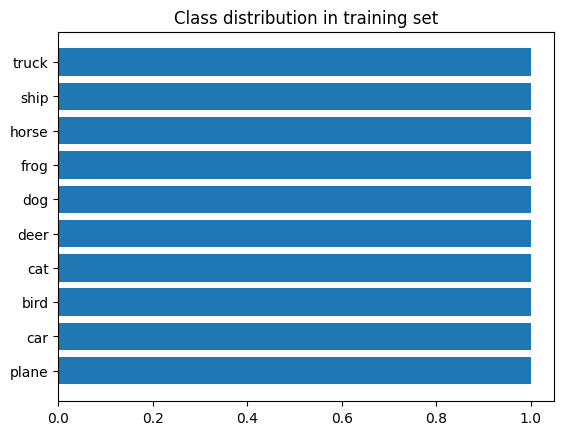

In [11]:

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

CLASS, counts = np.unique(trainset.classes, return_counts=True)
plt.barh(classes, counts)
plt.title('Class distribution in training set')

Text(0.5, 1.0, 'Class distribution in testing set')

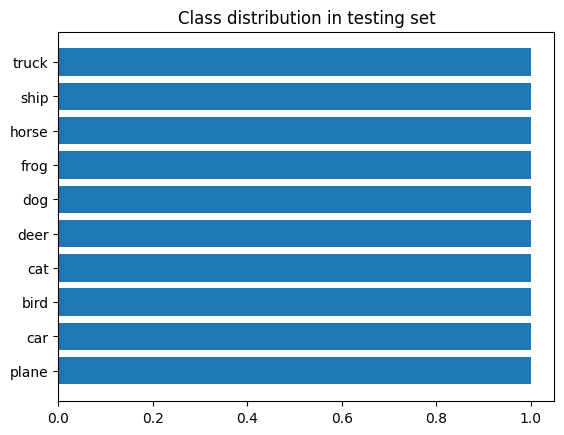

In [12]:
CLASS, counts = np.unique(testset.classes, return_counts=True)
plt.barh(classes, counts)
plt.title('Class distribution in testing set')

# Purposed Model

In [13]:
#Simple_dropout -> dropout 0.2
class Simple_dropout(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5, padding  = 2) #64
        self.conv2 = nn.Conv2d(6, 16, 3,  padding  = 1) #64
        self.pool = nn.MaxPool2d(2, 2) #32
        self.dropout = nn.Dropout(0.2)
        self.conv3 = nn.Conv2d(16, 32, 3, padding  = 1) #16
        self.conv4 = nn.Conv2d(32, 32, 3,  padding  = 1) #16
       # self.pool  #16

        self.fc1 = nn.Linear(32 * 16 * 16, 120)
        self.fc2 = nn.Linear(120, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(F.relu(self.conv2(x)))
        x = F.relu(self.conv3(x))
        x = self.pool(F.relu(self.conv4(x)))

        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = self.dropout(x)

        x = self.fc2(x)
        return x


net = Simple_dropout().to(device)
#calc parameters
total_params = sum(p.numel() for p in net.parameters())
total_trainable_params = sum(p.numel() for p in net.parameters() if p.requires_grad)

print(f"Total number of parameters: {total_params}")
print(f"Total number of trainable parameters: {total_trainable_params}")


Total number of parameters: 999594
Total number of trainable parameters: 999594


In [14]:
def calc_output_size():
    i = 32
    d = 1
    k = 5
    s = 1
    p = 2
    o = (i + 2*p - k - (k-1)*(d-1))/s + 1
    print(o)
calc_output_size()

32.0


In [15]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
#optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)
optimizer = optim.Adam(net.parameters(), lr=0.001)

In [16]:
# the class with the highest energy is what we choose as prediction
def accurcy(outputs, labels):
    _, pred = torch.max(outputs.data, 1)
    return ((pred == labels).sum().item())

In [17]:
def evaluate():
    correct = 0
    total = 0
    running_loss = 0.0
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for data in testloader:
            images, labels = data[0].to(device) , data[1].to(device)
            # calculate outputs by running images through the network
            outputs = net(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * images.size(0)

            correct += accurcy(outputs, labels)
            total += labels.size(0)
    return (running_loss/len(testset)) , (correct / total)


In [ ]:
train_loss = []
test_loss = []
train_acc = []
test_acc = []

for epoch in range(EPOCHS):  # loop over the dataset multiple times

    correct = 0.0
    total_batches = 0
    running_loss = 0.0

    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device) , data[1].to(device)
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs) # 4 batch * 10 class_propability
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        #train loss and accuracy
        running_loss += loss.item() * inputs.size(0)
        correct += accurcy(outputs, labels)
        total_batches += labels.size(0)

    train_acc.append(correct / total_batches)
    train_loss.append(running_loss / len(trainset))

    t_loss, t_acc = evaluate()
    test_acc.append(t_acc)
    test_loss.append(t_loss)

    print(f'{epoch + 1} / {EPOCHS} | train_loss: {(running_loss/len(trainset)):.4f} | test_loss: {t_loss:.2f}')
    print(f'Train Accuracy: {(100 * train_acc[epoch]):.2f}% ')
    print(f'Test Accuracy : {(100 * test_acc[epoch]):.2f}% ')
    net.train()

print('Finished Training')


1 / 70 | train_loss: 1.4878 | test_loss: 1.22
Train Accuracy: 45.62% 
Test Accuracy : 55.73% 
2 / 70 | train_loss: 1.1590 | test_loss: 1.09
Train Accuracy: 58.69% 
Test Accuracy : 61.65% 
3 / 70 | train_loss: 1.0336 | test_loss: 0.99
Train Accuracy: 63.60% 
Test Accuracy : 64.52% 
4 / 70 | train_loss: 0.9613 | test_loss: 0.99
Train Accuracy: 66.09% 
Test Accuracy : 65.07% 
5 / 70 | train_loss: 0.9072 | test_loss: 0.99
Train Accuracy: 67.83% 
Test Accuracy : 65.75% 
6 / 70 | train_loss: 0.8625 | test_loss: 0.97
Train Accuracy: 69.67% 
Test Accuracy : 67.17% 
7 / 70 | train_loss: 0.8351 | test_loss: 0.96
Train Accuracy: 70.38% 
Test Accuracy : 66.46% 
8 / 70 | train_loss: 0.7992 | test_loss: 0.96
Train Accuracy: 71.81% 
Test Accuracy : 66.85% 
9 / 70 | train_loss: 0.7780 | test_loss: 1.00
Train Accuracy: 72.59% 
Test Accuracy : 66.75% 
10 / 70 | train_loss: 0.7505 | test_loss: 0.98
Train Accuracy: 73.57% 
Test Accuracy : 67.81% 
11 / 70 | train_loss: 0.7331 | test_loss: 1.02
Train Accura

In [ ]:
# Plotting both the curves simultaneously
plt.plot(train_loss, color='b', label='train_loss')
plt.plot(test_loss, color='r', label='test_loss')

# Naming the x-axis, y-axis and the whole graph
plt.xlabel("EPOCHS")
plt.ylabel("LOSS")
plt.title("loss")

# Adding legend, which helps us recognize the curve according to it's color
plt.legend()

# To load the display window
plt.show()

In [ ]:
# Plotting both the curves simultaneously
plt.plot(train_acc, color='b', label='train_scc')
plt.plot(test_acc, color='r', label='test_scc')

# Naming the x-axis, y-axis and the whole graph
plt.xlabel("EPOCHS")
plt.ylabel("ACCURACY")
plt.title("ACCURACY")

# Adding legend, which helps us recognize the curve according to it's color
plt.legend()

# To load the display window
plt.show()

In [ ]:

from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

y_pred = []
y_true = []

# iterate over test data
for data in testloader:
        inputs, labels = data[0].to(device) , data[1].to(device)
        output = net(inputs) # Feed Network

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) # Save Prediction

        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)
plt.savefig('output.png')

In [ ]:

def matrix(input, target):
  recall = MulticlassRecall(num_classes=10)
  precision = MulticlassPrecision(num_classes=10)
  recall.update(input, target)
  precision.update(input, target)

  f1_score = multiclass_f1_score(input, target, num_classes = 10)
  recall = precision.compute()
  precision = precision.compute()
  print(f1_score,recall,precision)
  return f1_score,recall,precision

In [ ]:
f1_score,recall,precision = matrix(torch.tensor(y_true),torch.tensor(y_pred) )

***NOTEs:***

- cat and dog can't differentiate

- cat and birds is the lowest

In [ ]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}
#https://sybernix.medium.com/drawing-loss-curves-for-deep-neural-network-training-in-pytorch-ac617b24c388

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device)  , data[1].to(device)
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, pred in zip(labels, predictions):
            if label == pred:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1

keys = []
values = []
# print accuracy for each class
for classname, correct_count in correct_pred.items():
    keys.append(classname), values.append(correct_count / total_pred[classname])
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class {classname:5s} is {accuracy:.1f} %')

In [ ]:
plt.barh(keys, values)
plt.title('Accuracy for class')

## Human visualize test

In [ ]:
dataiter = iter(testloader)
images, labels = next(dataiter)
NUM_SAMPLES = batch_size
plt.figure(figsize=(10,10))
for i in range(NUM_SAMPLES):
    plt.subplot(4,4,i+1)
    plt.imshow((images[i] / 2 + 0.5).permute(1, 2, 0) ) #chnage the indexes 32×32×3
    plt.title('label: {}'.format(classes[labels[i]]))
    plt.axis('off')

In [ ]:
_, predicted = torch.max(outputs, 1)
print('GroundTruth:', ' | '.join(f'{classes[labels[j]]:5s}' for j in range(len(images))))
print('Predicted:  ', ' | '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(len(predicted))))

# Traials

## Simple models

In [ ]:
#Simple model1
class Simple_model1(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 3, padding  = 1) #32
        self.conv2 = nn.Conv2d(6, 16, 3,  padding  = 1) #32
        self.pool = nn.MaxPool2d(2, 2) #16

        self.conv3 = nn.Conv2d(16, 32, 3, padding  = 1) #16
        self.conv4 = nn.Conv2d(32, 32, 3,  padding  = 1) #16
       # self.pool  #8

        self.fc1 = nn.Linear(32 * 8 * 8, 120)
        self.fc2 = nn.Linear(120, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(F.relu(self.conv2(x)))

        x = F.relu(self.conv3(x))
        x = self.pool(F.relu(self.conv4(x)))

        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Simple_model1().to(device)
#calc parameters
total_params = sum(p.numel() for p in net.parameters())
total_trainable_params = sum(p.numel() for p in net.parameters() if p.requires_grad)
print(f"Total number of parameters: {total_params}")
print(f"Total number of trainable parameters: {total_trainable_params}")


Total number of parameters: 269210
Total number of trainable parameters: 269210


In [ ]:
#Simple model2 -> REMOVE LAYER
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 3, padding  = 1) #32
        self.conv2 = nn.Conv2d(6, 16, 3,  padding  = 1) #32
        self.pool = nn.MaxPool2d(2, 2) #16

        self.conv3 = nn.Conv2d(16, 32, 3, padding  = 1) #16
        self.conv4 = nn.Conv2d(32, 32, 3,  padding  = 1) #16
       # self.pool  #8

        self.fc1 = nn.Linear(32 * 8 * 8, 120)
        self.fc2 = nn.Linear(120, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(F.relu(self.conv2(x)))

        x = F.relu(self.conv3(x))
        x = self.pool(F.relu(self.conv4(x)))

        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


net = Net().to(device)
#calc parameters
total_params = sum(p.numel() for p in net.parameters())
total_trainable_params = sum(p.numel() for p in net.parameters() if p.requires_grad)

print(f"Total number of parameters: {total_params}")
print(f"Total number of trainable parameters: {total_trainable_params}")


Total number of parameters: 262314
Total number of trainable parameters: 262314


In [ ]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
#optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)
optimizer = optim.Adam(net.parameters(), lr=0.001)

In [ ]:
# the class with the highest energy is what we choose as prediction
def accurcy(outputs, labels):
    _, pred = torch.max(outputs.data, 1)
    return ((pred == labels).sum().item())

In [ ]:
def evaluate():
    correct = 0
    total = 0
    running_loss = 0.0
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for data in testloader:
            images, labels = data[0].to(device) , data[1].to(device)
            # calculate outputs by running images through the network
            outputs = net(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * images.size(0)

            correct += accurcy(outputs, labels)
            total += labels.size(0)
    return (running_loss/len(testset)) , (correct / total)


In [ ]:
train_loss = []
test_loss = []
train_acc = []
test_acc = []

for epoch in range(EPOCHS):  # loop over the dataset multiple times

    correct = 0.0
    total_batches = 0
    running_loss = 0.0

    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device) , data[1].to(device)
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs) # 4 batch * 10 class_propability
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        #train loss and accuracy
        running_loss += loss.item() * inputs.size(0)
        correct += accurcy(outputs, labels)
        total_batches += labels.size(0)

    train_acc.append(correct / total_batches)
    train_loss.append(running_loss / len(trainset))

    t_loss, t_acc = evaluate()
    test_acc.append(t_acc)
    test_loss.append(t_loss)

    print(f'{epoch + 1} / {EPOCHS} | train_loss: {(running_loss/len(trainset)):.4f} | test_loss: {t_loss:.2f}')
    print(f'Train Accuracy: {(100 * train_acc[epoch]):.2f}% ')
    print(f'Test Accuracy : {(100 * test_acc[epoch]):.2f}% ')
    net.train()

print('Finished Training')


1 / 70 | train_loss: 1.3748 | test_loss: 1.08
Train Accuracy: 50.45% 
Test Accuracy : 61.59% 
2 / 70 | train_loss: 1.0040 | test_loss: 0.95
Train Accuracy: 64.62% 
Test Accuracy : 67.15% 
3 / 70 | train_loss: 0.8592 | test_loss: 0.92
Train Accuracy: 69.92% 
Test Accuracy : 68.31% 
4 / 70 | train_loss: 0.7568 | test_loss: 0.98
Train Accuracy: 73.52% 
Test Accuracy : 67.36% 
5 / 70 | train_loss: 0.6821 | test_loss: 0.92
Train Accuracy: 75.90% 
Test Accuracy : 69.48% 
6 / 70 | train_loss: 0.6193 | test_loss: 0.96
Train Accuracy: 78.04% 
Test Accuracy : 69.72% 
7 / 70 | train_loss: 0.5656 | test_loss: 0.99
Train Accuracy: 80.01% 
Test Accuracy : 69.15% 
8 / 70 | train_loss: 0.5164 | test_loss: 1.07
Train Accuracy: 81.61% 
Test Accuracy : 69.34% 
9 / 70 | train_loss: 0.4731 | test_loss: 1.19
Train Accuracy: 83.16% 
Test Accuracy : 67.33% 
10 / 70 | train_loss: 0.4318 | test_loss: 1.22
Train Accuracy: 84.76% 
Test Accuracy : 67.75% 
11 / 70 | train_loss: 0.3964 | test_loss: 1.33
Train Accura

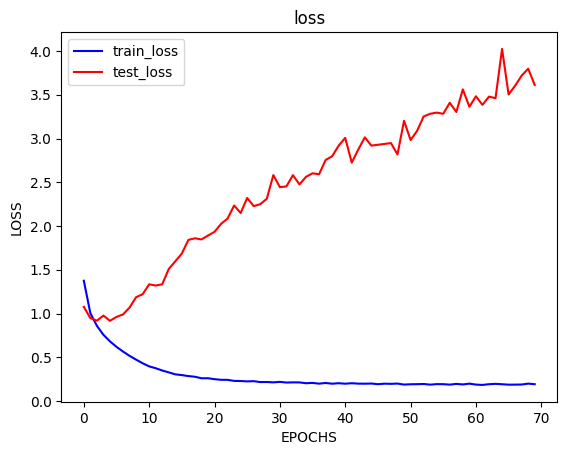

In [ ]:
# Plotting both the curves simultaneously
plt.plot(train_loss, color='b', label='train_loss')
plt.plot(test_loss, color='r', label='test_loss')

# Naming the x-axis, y-axis and the whole graph
plt.xlabel("EPOCHS")
plt.ylabel("LOSS")
plt.title("loss")

# Adding legend, which helps us recognize the curve according to it's color
plt.legend()

# To load the display window
plt.show()

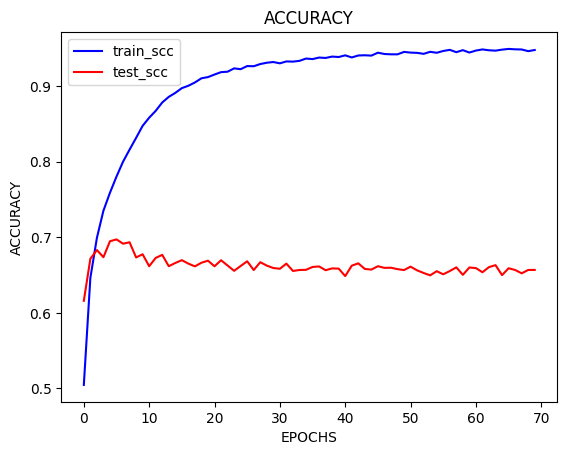

In [ ]:
# Plotting both the curves simultaneously
plt.plot(train_acc, color='b', label='train_scc')
plt.plot(test_acc, color='r', label='test_scc')

# Naming the x-axis, y-axis and the whole graph
plt.xlabel("EPOCHS")
plt.ylabel("ACCURACY")
plt.title("ACCURACY")

# Adding legend, which helps us recognize the curve according to it's color
plt.legend()

# To load the display window
plt.show()

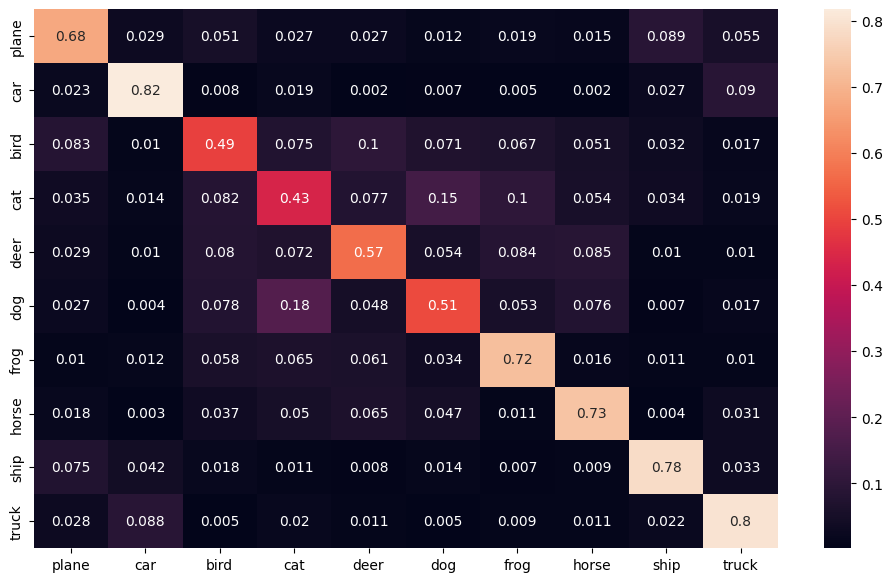

In [ ]:

from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

y_pred = []
y_true = []

# iterate over test data
for data in testloader:
        inputs, labels = data[0].to(device) , data[1].to(device)
        output = net(inputs) # Feed Network

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) # Save Prediction

        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)
plt.savefig('output.png')

***NOTEs:***

- cat and dog can't differentiate

- cat and birds is the lowest

In [ ]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}
#https://sybernix.medium.com/drawing-loss-curves-for-deep-neural-network-training-in-pytorch-ac617b24c388

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device)  , data[1].to(device)
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, pred in zip(labels, predictions):
            if label == pred:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1

keys = []
values = []
# print accuracy for each class
for classname, correct_count in correct_pred.items():
    keys.append(classname), values.append(correct_count / total_pred[classname])
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class {classname:5s} is {accuracy:.1f} %')

Accuracy for class plane is 67.1 %
Accuracy for class car   is 82.1 %
Accuracy for class bird  is 50.5 %
Accuracy for class cat   is 43.6 %
Accuracy for class deer  is 56.6 %
Accuracy for class dog   is 52.6 %
Accuracy for class frog  is 72.3 %
Accuracy for class horse is 73.4 %
Accuracy for class ship  is 78.5 %
Accuracy for class truck is 80.1 %


Text(0.5, 1.0, 'Accuracy for class')

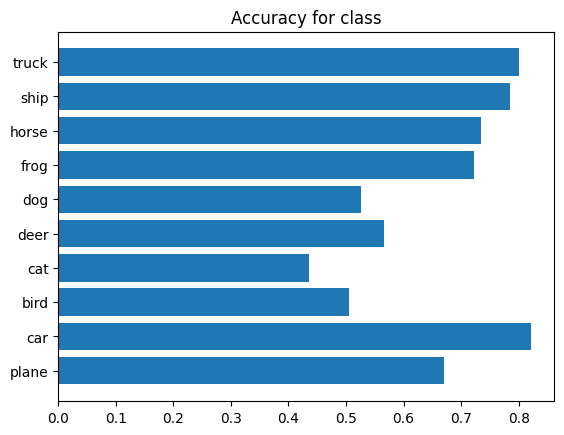

In [ ]:
plt.barh(keys, values)
plt.title('Accuracy for class')

## Simple model DROPOUUT

In [ ]:
#Simple_dropout -> dropout 0.2
class Simple_dropout(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5, padding  = 2) #64
        self.conv2 = nn.Conv2d(6, 16, 3,  padding  = 1) #64
        self.pool = nn.MaxPool2d(2, 2) #32
        self.dropout = nn.Dropout(0.2)
        self.conv3 = nn.Conv2d(16, 32, 3, padding  = 1) #16
        self.conv4 = nn.Conv2d(32, 32, 3,  padding  = 1) #16
       # self.pool  #16

        self.fc1 = nn.Linear(32 * 16 * 16, 120)
        self.fc2 = nn.Linear(120, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(F.relu(self.conv2(x)))
        x = F.relu(self.conv3(x))
        x = self.pool(F.relu(self.conv4(x)))

        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = self.dropout(x)

        x = self.fc2(x)
        return x


net = Simple_dropout().to(device)
#calc parameters
total_params = sum(p.numel() for p in net.parameters())
total_trainable_params = sum(p.numel() for p in net.parameters() if p.requires_grad)

print(f"Total nuber of parameters: {total_params}")
print(f"Total number of trainable parameters: {total_trainable_params}")


Total number of parameters: 999594
Total number of trainable parameters: 999594


In [ ]:
train_loss = []
test_loss = []
train_acc = []
test_acc = []

for epoch in range(EPOCHS):  # loop over the dataset multiple times

    correct = 0.0
    total_batches = 0
    running_loss = 0.0

    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device) , data[1].to(device)
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs) # 4 batch * 10 class_propability
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        #train loss and accuracy
        running_loss += loss.item() * inputs.size(0)
        correct += accurcy(outputs, labels)
        total_batches += labels.size(0)

    train_acc.append(correct / total_batches)
    train_loss.append(running_loss / len(trainset))

    t_loss, t_acc = evaluate()
    test_acc.append(t_acc)
    test_loss.append(t_loss)

    print(f'{epoch + 1} / {EPOCHS} | train_loss: {(running_loss/len(trainset)):.4f} | test_loss: {t_loss:.2f}')
    print(f'Train Accuracy: {(100 * train_acc[epoch]):.2f}% ')
    print(f'Test Accuracy : {(100 * test_acc[epoch]):.2f}% ')
    net.train()

print('Finished Training')


1 / 70 | train_loss: 1.4654 | test_loss: 1.26
Train Accuracy: 46.60% 
Test Accuracy : 54.28% 
2 / 70 | train_loss: 1.1575 | test_loss: 1.11
Train Accuracy: 58.59% 
Test Accuracy : 60.90% 
3 / 70 | train_loss: 1.0479 | test_loss: 1.12
Train Accuracy: 62.91% 
Test Accuracy : 61.30% 
4 / 70 | train_loss: 0.9904 | test_loss: 1.12
Train Accuracy: 65.08% 
Test Accuracy : 62.46% 
5 / 70 | train_loss: 0.9490 | test_loss: 1.02
Train Accuracy: 66.52% 
Test Accuracy : 64.57% 
6 / 70 | train_loss: 0.9150 | test_loss: 1.02
Train Accuracy: 67.59% 
Test Accuracy : 65.43% 
7 / 70 | train_loss: 0.8955 | test_loss: 1.03
Train Accuracy: 68.38% 
Test Accuracy : 64.73% 
8 / 70 | train_loss: 0.8729 | test_loss: 0.99
Train Accuracy: 69.26% 
Test Accuracy : 66.02% 
9 / 70 | train_loss: 0.8566 | test_loss: 0.99
Train Accuracy: 69.71% 
Test Accuracy : 66.05% 
10 / 70 | train_loss: 0.8434 | test_loss: 0.98
Train Accuracy: 70.28% 
Test Accuracy : 65.75% 
11 / 70 | train_loss: 0.8330 | test_loss: 0.99
Train Accura

## Simple model + Augmentation

In [ ]:
#Simple model1
class Simple_model1(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 3, padding  = 1) #32
        self.conv2 = nn.Conv2d(6, 16, 3,  padding  = 1) #32
        self.pool = nn.MaxPool2d(2, 2) #16

        self.conv3 = nn.Conv2d(16, 32, 3, padding  = 1) #16
        self.conv4 = nn.Conv2d(32, 32, 3,  padding  = 1) #16
       # self.pool  #8

        self.fc1 = nn.Linear(32 * 8 * 8, 120)
        self.fc2 = nn.Linear(120, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(F.relu(self.conv2(x)))

        x = F.relu(self.conv3(x))
        x = self.pool(F.relu(self.conv4(x)))

        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Simple_model1().to(device)
#calc parameters
total_params = sum(p.numel() for p in net.parameters())
total_trainable_params = sum(p.numel() for p in net.parameters() if p.requires_grad)
print(f"Total number of parameters: {total_params}")
print(f"Total number of trainable parameters: {total_trainable_params}")


Total number of parameters: 269210
Total number of trainable parameters: 269210


In [ ]:
#Simple model2 -> REMOVE LAYER
class Simple_model2(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 3, padding  = 2) #256
        self.conv2 = nn.Conv2d(6, 16, 3,  padding  = 1) #256
        self.pool = nn.MaxPool2d(2, 2) #128

        self.conv3 = nn.Conv2d(16, 32, 3, padding  = 1) #128
        self.conv4 = nn.Conv2d(32, 32, 3,  padding  = 1) #128
       # self.pool  #64

        self.fc1 = nn.Linear(32 * 64 * 64, 120)
        self.fc2 = nn.Linear(120, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(F.relu(self.conv2(x)))

        x = F.relu(self.conv3(x))
        x = self.pool(F.relu(self.conv4(x)))

        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


#net = Simple_model2().to(device)
#calc parameters
total_params = sum(p.numel() for p in net.parameters())
total_trainable_params = sum(p.numel() for p in net.parameters() if p.requires_grad)
print(f"Total number of parameters: {total_params}")
print(f"Total number of trainable parameters: {total_trainable_params}")


Total number of parameters: 15744906
Total number of trainable parameters: 15744906


In [ ]:
train_loss = []
test_loss = []
train_acc = []
test_acc = []

for epoch in range(EPOCHS):  # loop over the dataset multiple times

    correct = 0.0
    total_batches = 0
    running_loss = 0.0

    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device) , data[1].to(device)
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs) # 4 batch * 10 class_propability
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        #train loss and accuracy
        running_loss += loss.item() * inputs.size(0)
        correct += accurcy(outputs, labels)
        total_batches += labels.size(0)

    train_acc.append(correct / total_batches)
    train_loss.append(running_loss / len(trainset))

    t_loss, t_acc = evaluate()
    test_acc.append(t_acc)
    test_loss.append(t_loss)

    print(f'{epoch + 1} / {EPOCHS} | train_loss: {(running_loss/len(trainset)):.4f} | test_loss: {t_loss:.2f}')
    print(f'Train Accuracy: {(100 * train_acc[epoch]):.2f}% ')
    print(f'Test Accuracy : {(100 * test_acc[epoch]):.2f}% ')
    net.train()

print('Finished Training')


1 / 70 | train_loss: 1.5617 | test_loss: 1.34
Train Accuracy: 43.15% 
Test Accuracy : 51.24% 
2 / 70 | train_loss: 1.1795 | test_loss: 1.30
Train Accuracy: 57.61% 
Test Accuracy : 53.53% 
3 / 70 | train_loss: 0.8417 | test_loss: 1.42
Train Accuracy: 70.11% 
Test Accuracy : 53.91% 
4 / 70 | train_loss: 0.4875 | test_loss: 1.85
Train Accuracy: 82.84% 
Test Accuracy : 51.93% 
5 / 70 | train_loss: 0.2632 | test_loss: 2.61
Train Accuracy: 91.04% 
Test Accuracy : 50.80% 
6 / 70 | train_loss: 0.1792 | test_loss: 3.57
Train Accuracy: 94.02% 
Test Accuracy : 50.95% 
7 / 70 | train_loss: 0.1362 | test_loss: 3.97
Train Accuracy: 95.53% 
Test Accuracy : 50.29% 
8 / 70 | train_loss: 0.1200 | test_loss: 4.21
Train Accuracy: 96.23% 
Test Accuracy : 50.66% 
9 / 70 | train_loss: 0.1085 | test_loss: 4.78
Train Accuracy: 96.63% 
Test Accuracy : 49.64% 
10 / 70 | train_loss: 0.1015 | test_loss: 4.46
Train Accuracy: 96.91% 
Test Accuracy : 50.67% 
11 / 70 | train_loss: 0.0967 | test_loss: 4.57
Train Accura

KeyboardInterrupt: 

## Simple + DROPOUT + Augmentation

In [ ]:
#Simple model3 -> ADD CONV
class Simple_model3(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 3, padding  = 1) #256
        self.pool = nn.MaxPool2d(2, 2) #128

        self.conv2 = nn.Conv2d(6, 16, 3,  padding  = 1) #128
        self.conv3 = nn.Conv2d(16, 32, 3, padding  = 1) #128
        # self.pool  #64

        self.conv4 = nn.Conv2d(32, 32, 3,  padding  = 1) #64
        # self.pool  #32

        self.conv5 = nn.Conv2d(32, 64, 3, padding  = 1) #32
        # self.pool  #16

        self.conv6 = nn.Conv2d(64, 64, 3,  padding  = 1) #16
       # self.pool  #8
        self.dropout = nn.Dropout(0.3)

        self.fc1 = nn.Linear(64 * 8 * 8, 120)
        self.fc2 = nn.Linear(120, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.dropout(x)

        x = F.relu(self.conv2(x))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.dropout(x)

        x = self.pool(F.relu(self.conv4(x)))
        x = self.pool(F.relu(self.conv5(x)))
        x = self.pool(F.relu(self.conv6(x)))

        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = self.dropout(x)

        x = self.fc2(x)
        return x


net = Simple_model3().to(device)
#calc parameters
total_params = sum(p.numel() for p in net.parameters())
total_trainable_params = sum(p.numel() for p in net.parameters() if p.requires_grad)

print(f"Total number of parameters: {total_params}")
print(f"Total number of trainable parameters: {total_trainable_params}")


Total number of parameters: 563210
Total number of trainable parameters: 563210


In [ ]:
train_loss = []
test_loss = []
train_acc = []
test_acc = []

for epoch in range(EPOCHS):  # loop over the dataset multiple times

    correct = 0.0
    total_batches = 0
    running_loss = 0.0

    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device) , data[1].to(device)
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs) # 4 batch * 10 class_propability
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        #train loss and accuracy
        running_loss += loss.item() * inputs.size(0)
        correct += accurcy(outputs, labels)
        total_batches += labels.size(0)

    train_acc.append(correct / total_batches)
    train_loss.append(running_loss / len(trainset))

    t_loss, t_acc = evaluate()
    test_acc.append(t_acc)
    test_loss.append(t_loss)

    print(f'{epoch + 1} / {EPOCHS} | train_loss: {(running_loss/len(trainset)):.4f} | test_loss: {t_loss:.2f}')
    print(f'Train Accuracy: {(100 * train_acc[epoch]):.2f}% ')
    print(f'Test Accuracy : {(100 * test_acc[epoch]):.2f}% ')
    net.train()

print('Finished Training')


1 / 70 | train_loss: 2.2701 | test_loss: 2.30
Train Accuracy: 12.55% 
Test Accuracy : 10.00% 
2 / 70 | train_loss: 2.3046 | test_loss: 2.30
Train Accuracy: 9.89% 
Test Accuracy : 10.00% 
3 / 70 | train_loss: 2.3046 | test_loss: 2.30
Train Accuracy: 9.68% 
Test Accuracy : 10.00% 
4 / 70 | train_loss: 2.3045 | test_loss: 2.30
Train Accuracy: 9.90% 
Test Accuracy : 10.00% 
5 / 70 | train_loss: 2.3045 | test_loss: 2.31
Train Accuracy: 9.99% 
Test Accuracy : 10.00% 
6 / 70 | train_loss: 2.3046 | test_loss: 2.30
Train Accuracy: 9.82% 
Test Accuracy : 10.00% 
7 / 70 | train_loss: 2.3044 | test_loss: 2.30
Train Accuracy: 10.14% 
Test Accuracy : 10.00% 
8 / 70 | train_loss: 2.3046 | test_loss: 2.31
Train Accuracy: 10.05% 
Test Accuracy : 10.00% 
9 / 70 | train_loss: 2.3048 | test_loss: 2.30
Train Accuracy: 9.86% 
Test Accuracy : 10.00% 
10 / 70 | train_loss: 2.3045 | test_loss: 2.31
Train Accuracy: 9.96% 
Test Accuracy : 10.00% 
11 / 70 | train_loss: 2.3046 | test_loss: 2.30
Train Accuracy: 10.

KeyboardInterrupt: 

In [ ]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}
#https://sybernix.medium.com/drawing-loss-curves-for-deep-neural-network-training-in-pytorch-ac617b24c388

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device)  , data[1].to(device)
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, pred in zip(labels, predictions):
            if label == pred:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1

keys = []
values = []
# print accuracy for each class
for classname, correct_count in correct_pred.items():
    keys.append(classname), values.append(correct_count / total_pred[classname])
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class {classname:5s} is {accuracy:.1f} %')

In [ ]:
plt.barh(keys, values)
plt.title('Accuracy for class')

## Large model Augmentation + dropout

In [ ]:
class Large_model2(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 3, padding  = 2) #256
        self.conv2 = nn.Conv2d(6, 16, 3,  padding  = 1) #256
        self.pool = nn.MaxPool2d(2, 2) #128

        self.conv3 = nn.Conv2d(16, 32, 3, padding  = 1) #128
        self.conv4 = nn.Conv2d(32, 32, 3,  padding  = 1) #128
       # self.pool  #64

        self.fc1 = nn.Linear(32 * 64 * 64, 64)
        self.fc2 = nn.Linear(64, 10)
        self.dropout = nn.Dropout(0.7)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(F.relu(self.conv2(x)))

        x = F.relu(self.conv3(x))
        x = self.pool(F.relu(self.conv4(x)))

        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x


net = Large_model2().to(device)
#calc parameters
total_params = sum(p.numel() for p in net.parameters())
total_trainable_params = sum(p.numel() for p in net.parameters() if p.requires_grad)

print(f"Total number of parameters: {total_params}")
print(f"Total number of trainable parameters: {total_trainable_params}")


Total number of parameters: 8404258
Total number of trainable parameters: 8404258


In [ ]:
train_loss = []
test_loss = []
train_acc = []
test_acc = []

for epoch in range(EPOCHS):  # loop over the dataset multiple times

    correct = 0.0
    total_batches = 0
    running_loss = 0.0

    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device) , data[1].to(device)
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs) # 4 batch * 10 class_propability
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        #train loss and accuracy
        running_loss += loss.item() * inputs.size(0)
        correct += accurcy(outputs, labels)
        total_batches += labels.size(0)

    train_acc.append(correct / total_batches)
    train_loss.append(running_loss / len(trainset))

    t_loss, t_acc = evaluate()
    test_acc.append(t_acc)
    test_loss.append(t_loss)

    print(f'{epoch + 1} / {EPOCHS} | train_loss: {(running_loss/len(trainset)):.4f} | test_loss: {t_loss:.2f}')
    print(f'Train Accuracy: {(100 * train_acc[epoch]):.2f}% ')
    print(f'Test Accuracy : {(100 * test_acc[epoch]):.2f}% ')
    net.train()

print('Finished Training')


1 / 70 | train_loss: 2.3058 | test_loss: 2.31
Train Accuracy: 10.00% 
Test Accuracy : 10.00% 
2 / 70 | train_loss: 2.3060 | test_loss: 2.31
Train Accuracy: 10.00% 
Test Accuracy : 10.00% 
3 / 70 | train_loss: 2.3059 | test_loss: 2.31
Train Accuracy: 10.00% 
Test Accuracy : 10.00% 
4 / 70 | train_loss: 2.3058 | test_loss: 2.31
Train Accuracy: 10.00% 
Test Accuracy : 10.00% 


KeyboardInterrupt: 

## Large model Augmentation + dropout + batch

In [ ]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding):
        super(ConvBlock, self).__init__()
        self.Conv = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride, padding=padding)
        self.Batch_Norm = nn.BatchNorm2d(num_features=out_channels)
        self.Activ_Func = nn.ReLU()

    def forward(self, x):
        x = self.Conv(x)
        x = self.Batch_Norm(x)
        x = self.Activ_Func(x)

        return x

In [ ]:
class Large_model2(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 8, 3, padding  = 2)  #256
        self.conv2 = ConvBlock(in_channels=8, out_channels=16, kernel_size=(3,3), stride=(1,1), padding=(1,1))#256
        self.pool = nn.MaxPool2d(2, 2) #128

        self.conv3 = nn.Conv2d(16, 32, 3, padding  = 2) #128
        self.conv4 = ConvBlock(in_channels=32, out_channels=64, kernel_size=(3,3), stride=(1,1), padding=(1,1))#128
        #64
        self.conv5 = ConvBlock(in_channels=64, out_channels=64, kernel_size=(3,3), stride=(1,1), padding=(1,1))
        self.conv6 = ConvBlock(in_channels=64, out_channels=128, kernel_size=(3,3), stride=(1,1), padding=(1,1))
        #32

        self.fc1 = nn.Linear(128*16*16, 32)
        self.fc2 = nn.Linear(32, 10)
        self.dropout = nn.Dropout(0.4)
        self.dropout2 = nn.Dropout(0.7)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.dropout(x)
        x = self.pool(x)

        x = F.relu(self.conv3(x))
        x = self.pool(F.relu(self.conv4(x)))

        x = self.pool(F.relu(self.conv5(x)))

        x = self.pool(F.relu(self.conv6(x)))

        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = self.dropout2(x)
        x = self.fc2(x)
        return x


net = Large_model2().to(device)
#calc parameters
total_params = sum(p.numel() for p in net.parameters())
total_trainable_params = sum(p.numel() for p in net.parameters() if p.requires_grad)

print(f"Total number of parameters: {total_params}")
print(f"Total number of trainable parameters: {total_trainable_params}")


Total number of parameters: 1184794
Total number of trainable parameters: 1184794


### Train

In [ ]:
train_loss = []
test_loss = []
train_acc = []
test_acc = []

for epoch in range(EPOCHS):  # loop over the dataset multiple times

    correct = 0.0
    total_batches = 0
    running_loss = 0.0

    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device) , data[1].to(device)
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs) # 4 batch * 10 class_propability
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        #train loss and accuracy
        running_loss += loss.item() * inputs.size(0)
        correct += accurcy(outputs, labels)
        total_batches += labels.size(0)

    train_acc.append(correct / total_batches)
    train_loss.append(running_loss / len(trainset))

    t_loss, t_acc = evaluate()
    test_acc.append(t_acc)
    test_loss.append(t_loss)

    print(f'{epoch + 1} / {EPOCHS} | train_loss: {(running_loss/len(trainset)):.4f} | test_loss: {t_loss:.2f}')
    print(f'Train Accuracy: {(100 * train_acc[epoch]):.2f}% ')
    print(f'Test Accuracy : {(100 * test_acc[epoch]):.2f}% ')
    net.train()

print('Finished Training')


1 / 70 | train_loss: 2.3680 | test_loss: 2.37
Train Accuracy: 10.26% 
Test Accuracy : 10.48% 
2 / 70 | train_loss: 2.3686 | test_loss: 2.37
Train Accuracy: 10.24% 
Test Accuracy : 9.86% 
3 / 70 | train_loss: 2.3715 | test_loss: 2.37
Train Accuracy: 10.21% 
Test Accuracy : 10.29% 
4 / 70 | train_loss: 2.3714 | test_loss: 2.37
Train Accuracy: 10.03% 
Test Accuracy : 10.24% 
5 / 70 | train_loss: 2.3713 | test_loss: 2.37
Train Accuracy: 10.25% 
Test Accuracy : 10.12% 
6 / 70 | train_loss: 2.3697 | test_loss: 2.36
Train Accuracy: 10.17% 
Test Accuracy : 10.54% 
